In [1]:
import os
import pickle

import numpy as np
import netket as nk

from src.qm_utils.lattice.lattice import Lattice2D
from src.netket_compat import get_sector_constraints
from brillouin_zones import construct_brillouin_zones

/home/cwpark/acband-laughlin-instability/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


∣NK⟩ Tip: uv is a replacement for pip which helps you follow good software practices.

In [2]:
N_data_path = "data/supple_d/ed_spectrum_20_27_0.800_256_64_20251119_184801.pkl"
N_minus_2_data_path = "data/supple_d/ed_spectrum_18_27_0.800_256_64_20251119_202725.pkl"
N = 20
N_s = 27

# N_data_path = "data/supple_d/ed_spectrum_21_28_0.800_256_64_20251119_191738.pkl"
# N_minus_2_data_path = "data/supple_d/ed_spectrum_19_28_0.800_256_64_20251120_004155.pkl"
# N = 21
# N_s = 28

In [3]:
# load pickle
with open(N_data_path, 'rb') as f:
    N_data = pickle.load(f)

with open(N_minus_2_data_path, 'rb') as f:
    N_minus_2_data = pickle.load(f)

"""
data format:
{
    'k_coms': k_coms_flatten,
    'energies': energies_flatten,
    'N_f': N_f,
    'N_s': N_s,
    'K': K,
    'fourier_resolution': fourier_resolution,
    'G_radius': G_radius,
    'a_M': a_M,
    'lB': lB,
    'com_momentums': com_momentums,
    'eigenvalues': eigenvalues,
    'eigenvectors': eigenvectors,
    'lattice': lattice,
    'recip_lattice': recip_lattice,
    'bz': bz_N_s,
}
"""

"\ndata format:\n{\n    'k_coms': k_coms_flatten,\n    'energies': energies_flatten,\n    'N_f': N_f,\n    'N_s': N_s,\n    'K': K,\n    'fourier_resolution': fourier_resolution,\n    'G_radius': G_radius,\n    'a_M': a_M,\n    'lB': lB,\n    'com_momentums': com_momentums,\n    'eigenvalues': eigenvalues,\n    'eigenvectors': eigenvectors,\n    'lattice': lattice,\n    'recip_lattice': recip_lattice,\n    'bz': bz_N_s,\n}\n"

In [4]:
if "bz" in N_data:
    bz = N_data['bz']
else:
    a_M = 1
    sqrt3 = np.sqrt(3)
    e1 = np.array([1, 0])
    e2 = np.array([0, 1])
    a1 = a_M * e2
    a2 = a_M * ((-sqrt3 / 2) * e1 + (1 / 2) * e2)
    lattice = Lattice2D(np.stack([a1, a2]))
    bz = construct_brillouin_zones(lattice)
    bz = bz[N_s]

In [5]:
zero_idx = bz.zero()
GS_vec_N = N_data['eigenvectors'][zero_idx][:, 0]  # ground state vector for N particles
GS_vec_N_minus_2 = N_minus_2_data['eigenvectors'][zero_idx][:, 0]  # ground state vector for N-2 particles

constaints_N = get_sector_constraints(bz, N)
constaints_N_minus_2 = get_sector_constraints(bz, N - 2)


# construct sparse representation of pairing gap function
full_fock = nk.hilbert.SpinOrbitalFermions(N_s, s=None, n_fermions=None)
N_subspaces = nk.hilbert.SpinOrbitalFermions(N_s, s=None, n_fermions=N, constraint=constaints_N[zero_idx])
N_minus_2_subspaces = nk.hilbert.SpinOrbitalFermions(N_s, s=None, n_fermions=N - 2, constraint=constaints_N_minus_2[zero_idx])

In [ ]:
import itertools
import scipy

def get_indices_by_bitcount(total_bits, n_ones):
    # unused
    combs = itertools.combinations(range(total_bits), n_ones)
    
    indices = []
    for positions in combs:
        val = 0
        for p in positions:
            val |= (1 << p)
        indices.append(val)
    
    return np.array(indices, dtype=np.int32)

def get_target_indices(full_fock: nk.hilbert.SpinOrbitalFermions, sector: nk.hilbert.SpinOrbitalFermions):
    indices = []
    for state in sector.states():
        idx = full_fock.states_to_numbers(state)
        indices.append(idx)
    return np.array(indices, dtype=np.int32)

def project_matrix(big_matrix, row_target_indices, col_target_indices, total):
    """
    전체 희소 행렬에서 특정 sector의 row/col만 추출하여 재구성
    """
    n_new_rows = len(row_target_indices)
    n_new_cols = len(col_target_indices)
    print(f"Target Shape: ({n_new_rows}, {n_new_cols})")

    print("Building Lookup Tables...")
    full_dim = 1 << total
    
    row_map = np.full(full_dim, -1, dtype=np.int32)
    row_map[row_target_indices] = np.arange(n_new_rows, dtype=np.int32)
    
    col_map = np.full(full_dim, -1, dtype=np.int32)
    col_map[col_target_indices] = np.arange(n_new_cols, dtype=np.int32)

    print("Filtering NNZ elements...")
    coo = big_matrix.tocoo()
    
    new_row_indices = row_map[coo.row]
    new_col_indices = col_map[coo.col]
    
    mask = (new_row_indices != -1) & (new_col_indices != -1)
    
    final_rows = new_row_indices[mask]
    final_cols = new_col_indices[mask]
    final_data = coo.data[mask]
    
    print(f"Constructing result matrix... (Kept {len(final_data)} / {coo.nnz} nnz)")
    result_matrix = scipy.sparse.coo_matrix(
        (final_data, (final_rows, final_cols)),
        shape=(n_new_rows, n_new_cols)
    ).tocsr()
    
    return result_matrix, row_target_indices, col_target_indices

In [ ]:
from netket.operator.fermion import destroy as c

pairing_gap_func = []
N_minus_2_sector_indices = get_target_indices(full_fock, N_minus_2_subspaces)
N_sector_indices = get_target_indices(full_fock, N_subspaces)


for k in range(N_s):
    neg_k = bz.neg(k)
    op = c(full_fock, neg_k) @ c(full_fock, k)
    full_sparse = op.to_sparse()
    sub_mat, _, _ = project_matrix(full_sparse, N_minus_2_sector_indices, N_sector_indices, N_s)
    value = np.dot(GS_vec_N_minus_2.conj(), sub_mat @ GS_vec_N)
    print(value)
    pairing_gap_func.append(value)

pairing_gap_func = np.array(pairing_gap_func)

/home/cwpark/acband-laughlin-instability/.venv/lib/python3.12/site-packages/netket/operator/_fermion2nd/jax.py:557: UserWarning: 
Consider using `netket.experimental.operator.ParticleNumberAndSpinConservingFermioperator2nd` to reduce the number of connected elements and
considerably reduce the computational cost.
You can convert this operator by calling `netket.experimental.operator.ParticleNumberAndSpinConservingFermioperator2nd.from_fermionoperator2nd`.

  super()._setup(self)


Target Shape: (173613, 32890)
Building Lookup Tables...
Filtering NNZ elements...
Constructing result matrix... (Kept 17808 / 33554432 nnz)
(0.059242296594106+0.10012417367507519j)
Target Shape: (173613, 32890)
Building Lookup Tables...
Filtering NNZ elements...
Constructing result matrix... (Kept 17806 / 33554432 nnz)
(0.3818094925242543-0.22591218851873962j)
Target Shape: (173613, 32890)
Building Lookup Tables...
Filtering NNZ elements...
Constructing result matrix... (Kept 17808 / 33554432 nnz)
(-0.059242296594105306-0.10012417367507408j)
Target Shape: (173613, 32890)
Building Lookup Tables...
Filtering NNZ elements...
Constructing result matrix... (Kept 17806 / 33554432 nnz)
(-0.3818094925242576+0.22591218851874556j)
Target Shape: (173613, 32890)
Building Lookup Tables...
Filtering NNZ elements...
Constructing result matrix... (Kept 17808 / 33554432 nnz)
(0.010908008137961223+0.018435397748627392j)
Target Shape: (173613, 32890)
Building Lookup Tables...
Filtering NNZ elements...
Co

In [23]:
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

def plot_gap_function(positions, gap_values, ax=None, scale_size=500, title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    magnitudes = np.abs(gap_values)
    phases = np.angle(gap_values) 
    
    norm_phases = (phases % (2 * np.pi)) / (2 * np.pi)
    colors_hsv = np.zeros((len(gap_values), 3))
    colors_hsv[:, 0] = norm_phases
    colors_hsv[:, 1] = 1.0 
    colors_hsv[:, 2] = 1.0 
    colors_rgb = hsv_to_rgb(colors_hsv)
    
    if np.max(magnitudes) > 0:
        sizes = (magnitudes / np.max(magnitudes)) * scale_size
    else:
        sizes = np.zeros_like(magnitudes)
        
    # Hexagon Boundary
    max_r = np.max(np.linalg.norm(positions, axis=1)) if len(positions) > 0 else 1.0
    angles_hex = np.linspace(0, 2*np.pi, 7) + np.pi/2
    hex_x = max_r * np.cos(angles_hex)
    hex_y = max_r * np.sin(angles_hex)
    ax.plot(hex_x, hex_y, color='gray', linewidth=2, zorder=0)
    
    # Scatter Plot
    ax.scatter(positions[:, 0], positions[:, 1], 
               s=sizes, c=colors_rgb, 
               edgecolors='black', linewidth=0.5, zorder=10)
    
    ax.set_aspect('equal')
    ax.axis('off')
    if title:
        ax.set_title(title, fontsize=16, y=1.05)

def add_phase_wheel(fig, loc):
    ax_wheel = fig.add_axes(loc, projection='polar')
    
    theta = np.linspace(0, 2*np.pi, 200)
    r = np.linspace(0.5, 1, 20)
    Theta, R = np.meshgrid(theta, r)
    
    ax_wheel.pcolormesh(Theta, R, Theta, cmap='hsv', shading='auto', vmin=0, vmax=2*np.pi)
    
    ax_wheel.set_yticks([])
    ax_wheel.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
    ax_wheel.set_xticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$'])
    ax_wheel.spines['polar'].set_visible(False)
    ax_wheel.set_title(r"arg$\Delta(k)$", pad=10, fontsize=10)

/tmp/ipykernel_2156310/1551684724.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


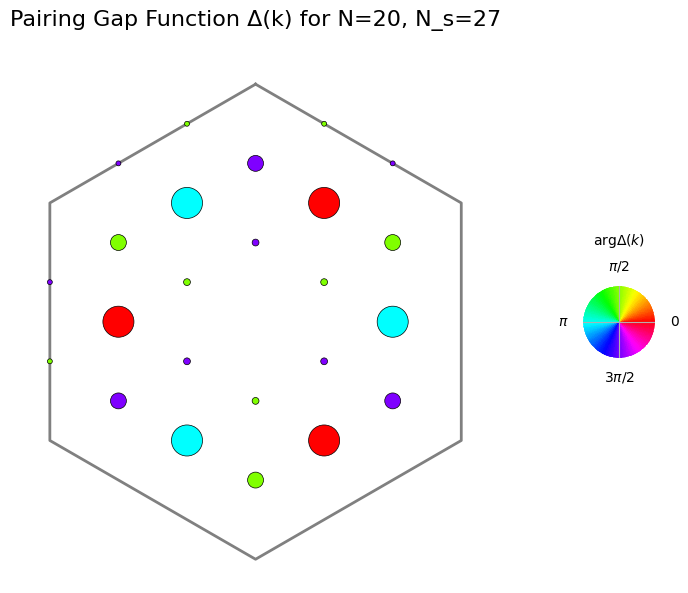

In [24]:
phi = -np.angle(pairing_gap_func[13])
global_gauge = np.exp(1j * phi)
k_points = bz.k_points

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
plot_gap_function(k_points, global_gauge * pairing_gap_func, ax=ax, scale_size=500, title=f"Pairing Gap Function Δ(k) for N={N}, N_s={N_s}")
add_phase_wheel(fig, loc=[0.92, 0.4, 0.12, 0.12])
plt.tight_layout()
plt.subplots_adjust(right=0.9)
plt.show()